
<div align="center">
  <a href="https://www.w-hs.de/maschinenbau-master-boh/">
    <img src="https://www.w-hs.de/typo3conf/ext/whs/Resources/Public/Images/Pagelayout/w-hs_pagelogo.png" 
    alt="Images" width="500" height="200">
  </a>
</div>
<br>
<h1 align="center"> Sondergebiete der Simulation</h1>
<h3 align="center"> WS 21/22 </h3>
<br>

<br>

### Credits:

* [benmoseley](https://github.com/benmoseley/harmonic-oscillator-pinn)

In [1]:
import sympy
from sympy import symbols, Function, diff, sin, cos, Matrix, Rational, Eq, solve, lambdify
import sympy.physics.mechanics as mech
mech.init_vprinting()

### Herleitung der Bewegungsgleichungen 

Ausführliche Beschreibung der Herleitung:
[Inverted Pendulum Legrange](https://github.com/lennart2810/InvertedPendulumSDS/blob/master/MKS/Inverted%20Pendulum%20Legrange.ipynb) 

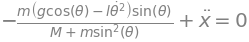

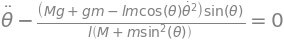

In [2]:
# symbolischen Variablen anlegen
t, l, M, m, g = symbols('t l M m g')

# Zwangsbedingung
y = 0

# generalisierte Koordinaten und deren Ableitungen:
x = Function('x')(t)
x_d = diff(x,t)
x_dd = diff(x_d,t)

theta = Function('theta')(t)
theta_d = diff(theta,t)
theta_dd = diff(theta,t,t)

# Kinematik
x2, y2 = x - l * sin(theta), y + l * cos(theta)
x2_d, y2_d = x2.diff(t), y2.diff(t)

# Legrange-Funktion
T = Rational(1,2) * M * (x_d)**2 + Rational(1,2) * m * (x2_d**2 + y2_d**2)
V = M * g * y + m * g * y2 
L = T - V

# Euler-Legrange
LE_x = diff(diff(L, x_d), t) - diff(L, x)
LE_theta = diff(diff(L, theta_d), t) - diff(L, theta)

# Nach x_dd und theta_dd umstellen
solutions = solve([LE_x, LE_theta], (x_dd, theta_dd), simplify=True) 
sol_x_dd = Eq(x_dd-solutions[x_dd], 0)
sol_theta_dd = Eq(theta_dd - solutions[theta_dd], 0)
display(sol_x_dd)
display(sol_theta_dd)
#display(Matrix([sol_x_dd, sol_theta_dd]))

In [3]:
# x_dd - (m*(g*cos(theta))) / ()...

### Umwandlung des symbolischen Gleichungssystems in numerische Funtkionen mit `sympy.lambdify`.

In [4]:
dxdt = lambdify(x_d, x_d)
dvdt = lambdify((t,g,M,m,l,theta,theta_d), solutions[x_dd])

dthetadt = lambdify(theta_d, theta_d)
domegadt = lambdify((t,g,M,m,l,theta,theta_d), solutions[theta_dd])

def dSdt(S, t, g, M, m, l):
    x, v, theta, omega = S
    return [
        dxdt(v),
        dvdt(t,g,M,m,l,theta, omega),
        dthetadt(omega),
        domegadt(t,g,M,m,l,theta,omega)
    ]

### Daten generieren

time.shape: (34,) <class 'numpy.ndarray'>
x.shape: (34,)
theta.shape: (34,)
data.shape: (34, 2)


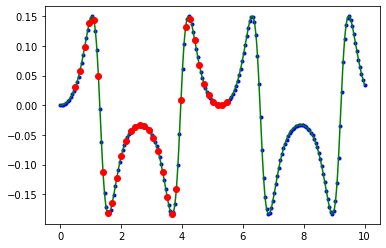

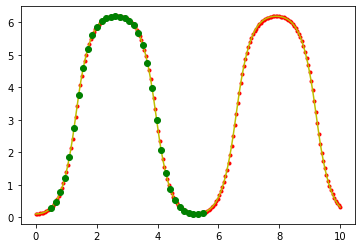

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interpolate

t1 = 10                          # s 
samples = 200                    # n 
t = np.linspace(0, t1, samples)  # s

g = 9.81                         # m/s^2
M = 5                            # kg
m = 1                            # kg
l = 1                            # m
F = 0                            # N

S0 = [0, 0, 0.1, 0]              # m, m/s, rad, rad/s

# numerische Lösung
ans = odeint(dSdt, y0=S0, t=t, args=(g, M, m, l))
x = ans.T[0]
theta = ans.T[2]

# numerische Lösung --> Lösungsfunktion interpolieren
# wird ausschließlich für DeepXDE benötigt (solution=func)
t_new = np.linspace(0, t1, samples+2000)    
x_f = interpolate.interp1d(t, x, 'cubic')
theta_f = interpolate.interp1d(t, theta, 'cubic')

# 'Messwerte'
a, b, i = 10, 110, 3 # jeden i. Punkt im Intervall [a,b] 
t_data = t[a:b:i]
x_data = x[a:b:i]
theta_data = theta[a:b:i]

# Data für NN zusammenfassen: (nur nötig wenn 1 Model mit 2 Outputs genutzt wird)
data = np.concatenate((x_data, theta_data)).reshape(2, len(t_data)).T
print('time.shape:', t_data.shape, type(t_data))
print('x.shape:', x_data.shape)
print('theta.shape:', theta_data.shape)
print('data.shape:', data.shape)


# Visualisierung 
plt.plot(t, x, 'b.')
plt.plot(t_new, x_f(t_new), 'g-')
plt.plot(t_data, data[:,0], 'ro') # data[:,1] --> x_data
plt.show()

plt.plot(t, theta, 'r.')
plt.plot(t_new, theta_f(t_new), 'y-')
plt.plot(t_data, data[:,1], 'go') # data[:,1] --> theta_data
plt.show()

In [6]:
import torch.nn as nn

class FCN(nn.Module):
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### *Messpunkte* mit Pytorch NN annähern

#### 1. Model für $x$
#### 2. Model für $\theta$

In [7]:
import torch
#from torch import cos, sin

t = torch.Tensor(t).view(-1,1)
t_data = torch.Tensor(t_data).view(-1,1)
x_data = torch.Tensor(x_data).view(-1,1)
theta_data = torch.Tensor(theta_data).view(-1,1)
data = torch.Tensor(data).view(-1,2)

print('t:', t.shape)
print('t_data:', t_data.shape)
print('x_data:', x_data.shape)
print('theta_data:', theta_data.shape)
print('data:', data.shape)

t: torch.Size([200, 1])
t_data: torch.Size([34, 1])
x_data: torch.Size([34, 1])
theta_data: torch.Size([34, 1])
data: torch.Size([34, 2])


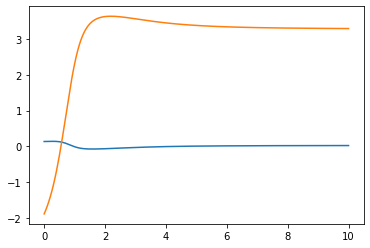

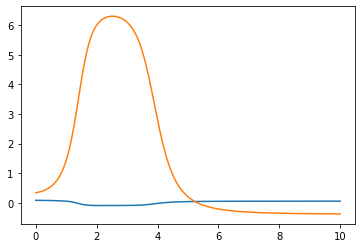

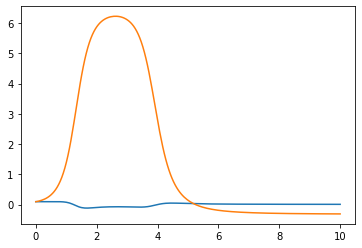

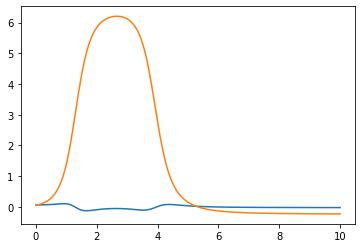

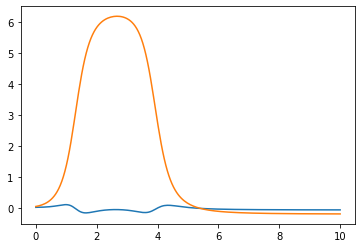

In [11]:
# NN Models trainieren:
# train standard neural network to fit training data

torch.manual_seed(123)

model_x = FCN(1,1,32,3)
optimizer_x = torch.optim.Adam(model_x.parameters(),lr=1e-3)

model_theta = FCN(1,1,32,3)
optimizer_theta = torch.optim.Adam(model_theta.parameters(),lr=1e-3)

model = FCN(1,2,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)


episodes = 1000
num_save_plot = round(episodes/5) # speicher 5 Plots

for i in range(1, episodes+1):
    
    #optimizer_x.zero_grad()
    #optimizer_theta.zero_grad()
    optimizer.zero_grad()

    #x_p = model_x(t_data)
    #theta_p = model_theta(t_data)
    pred = model(t_data)

    #loss_x = torch.mean((x_p - x_data)**2) 
    #loss_theta = torch.mean((theta_p - theta_data)**2) 
    loss = torch.mean((pred - data)**2) 
    
    # Debug
    """
    print('x_p:', x_p.shape)
    print('theta_p:', theta_p.shape)
    print('loss_x:', loss_x, loss_x.shape)
    print('loss_theta:', loss_theta, loss_theta.shape)
    test_x = loss_x.detach().numpy()
    print('test', test_x, type(test_x), test_x.shape)
    test_theta = loss_theta.detach().numpy()
    print('test', test_theta, type(test_theta), test_theta.shape)
    """

    
    #loss_x.backward() # Gradient berechnen
    #optimizer_x.step() # Backpropagation
    
    #loss_theta.backward() # Gradient berechnen
    #optimizer_theta.step() # Backpropagation
    
    loss.backward() # Gradient berechnen
    optimizer.step() # Backpropagation
    
    
    if (i) % num_save_plot == 0: 
        
        #x_p = model_x(t).detach()
        #theta_p = model_theta(t).detach()
        pred = model(t).detach()
        
        #plt.plot(t, x_p, 'r')
        #plt.plot(t, theta_p, 'g')
        #plt.show()
        plt.plot(t, pred)
        plt.show()